## Behaviour of xESMF when source grid includes halo

Demonstration of the behaviour of xESMF when remapping from source grids that contain (partly) duplicated rows and/or columns (halos).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
import scipy.sparse as sps
import clisops.core as clore
import clisops as cl
print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style='html');

#import warnings
#warnings.simplefilter("ignore") 

Using roocs/clisops in version 0.6.5
Using xESMF in version 0.6.1.dev0+ga04300a.d20210723


In [2]:
# Define paths to the data
path_mpiesmlr="./tos_Omon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_201001-201412.nc"
path_mpiesmhr="./tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_201001-201412.nc"

In [3]:
# Read the data with halo
ds_mpiesmlr_halo=xr.open_dataset(path_mpiesmlr).isel(time=0)
ds_mpiesmhr_halo=xr.open_dataset(path_mpiesmhr).isel(time=0)

# Read the data without halo (LR - first and last column, HR - first and last column, first 2 rows)
ds_mpiesmlr=xr.open_dataset(path_mpiesmlr).isel(time=0).isel(i=slice(1, 255))
ds_mpiesmhr=xr.open_dataset(path_mpiesmhr).isel(time=0).isel(i=slice(1, 801), j=slice(2,404))

### Plot the grid

In [4]:
import textwrap
def plot_curv_grid(ds, var="tos"):    
        lat=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
        lon=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]        
        if any([i==None for i in [lat, lon]]): 
            print(ds.attrs["source_id"],": Cannot identify latitude/longitude.")
            return
        plt.figure(figsize=(16, 9), dpi=120)
        plt.scatter(x=ds[lon], y=ds[lat], s=0.01)
        #x,y=np.meshgrid(ds[lon], ds[lat])
        #plt.scatter(x=x, y=y, s=0.01)
        try:
            plt.title("\n".join(textwrap.wrap(ds.attrs["source_id"] + "("+ds.attrs["source"].split("ocean:")[-1].split("\n")[0]+")", 120)))
        except (KeyError, IndexError):
            plt.title(ds.attrs["source_id"])   

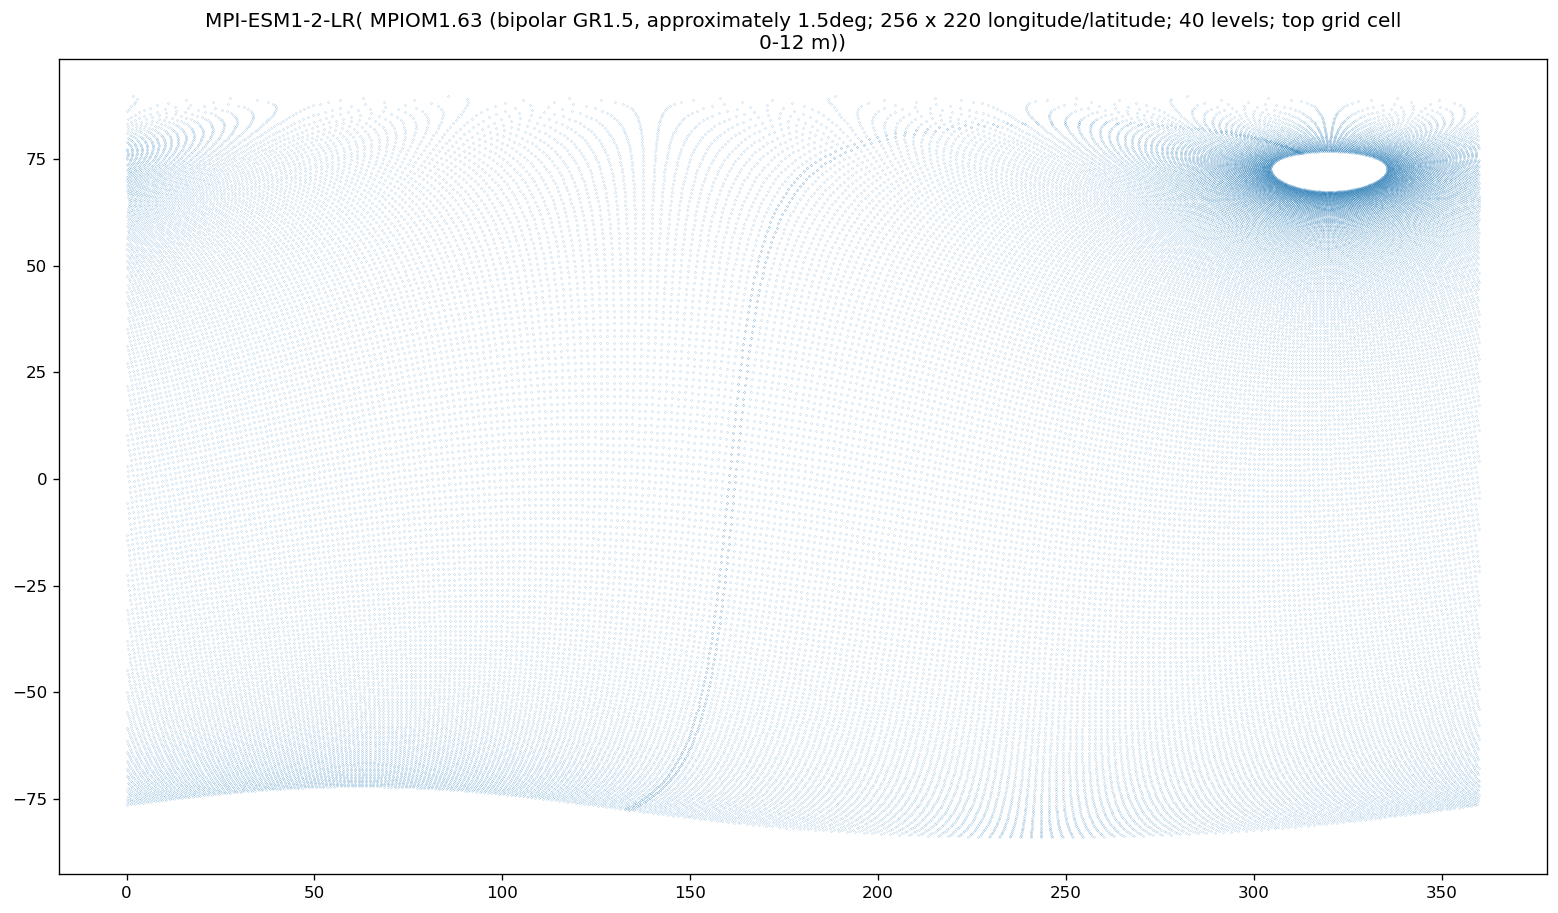

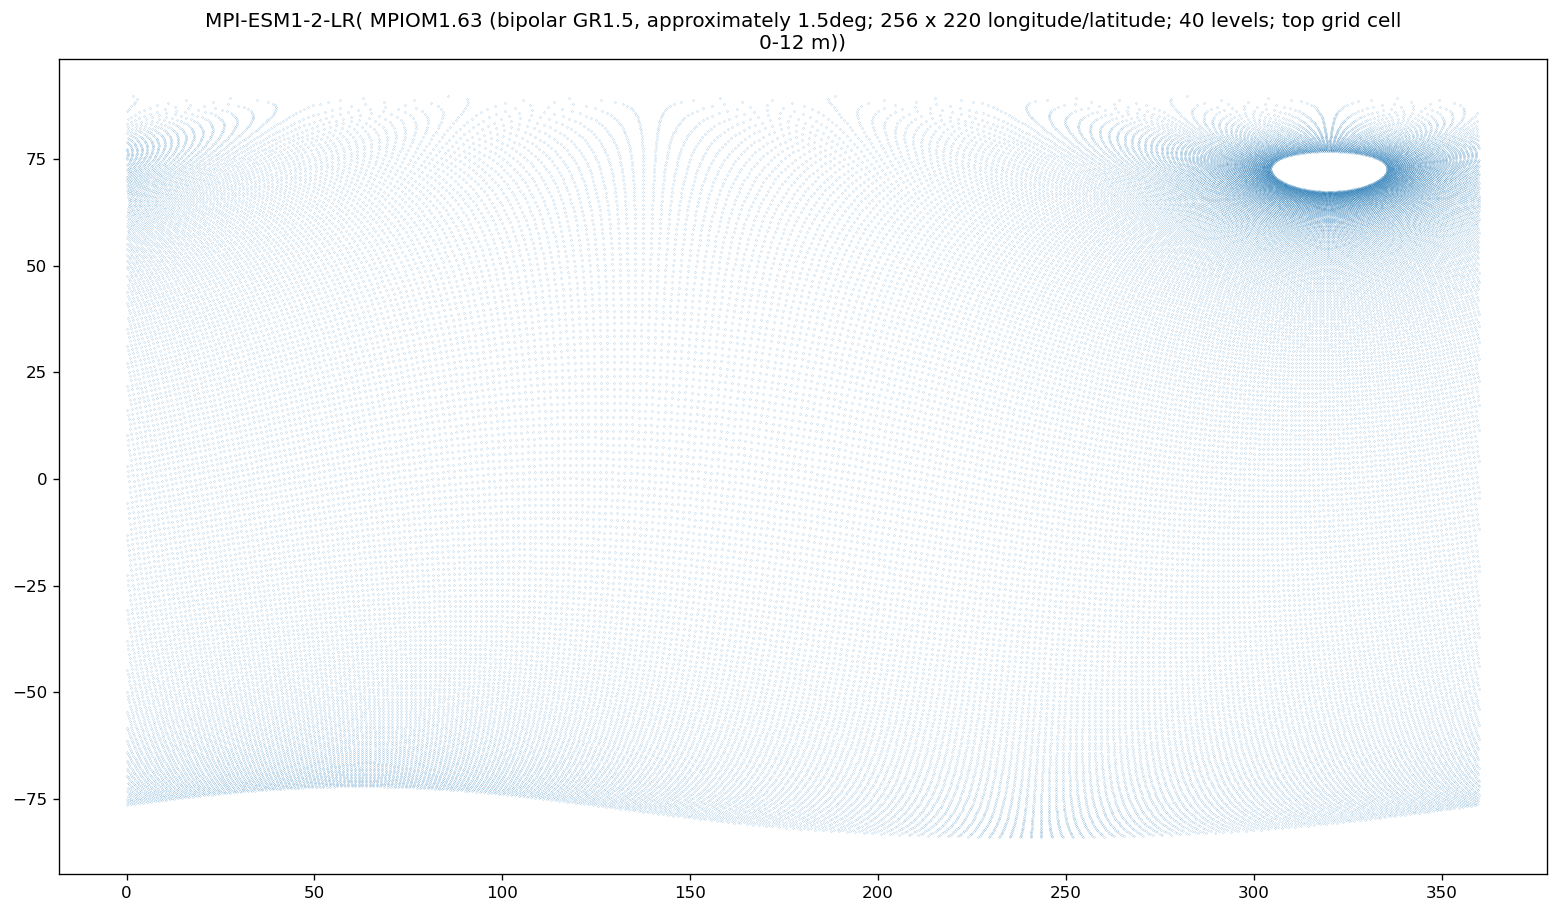

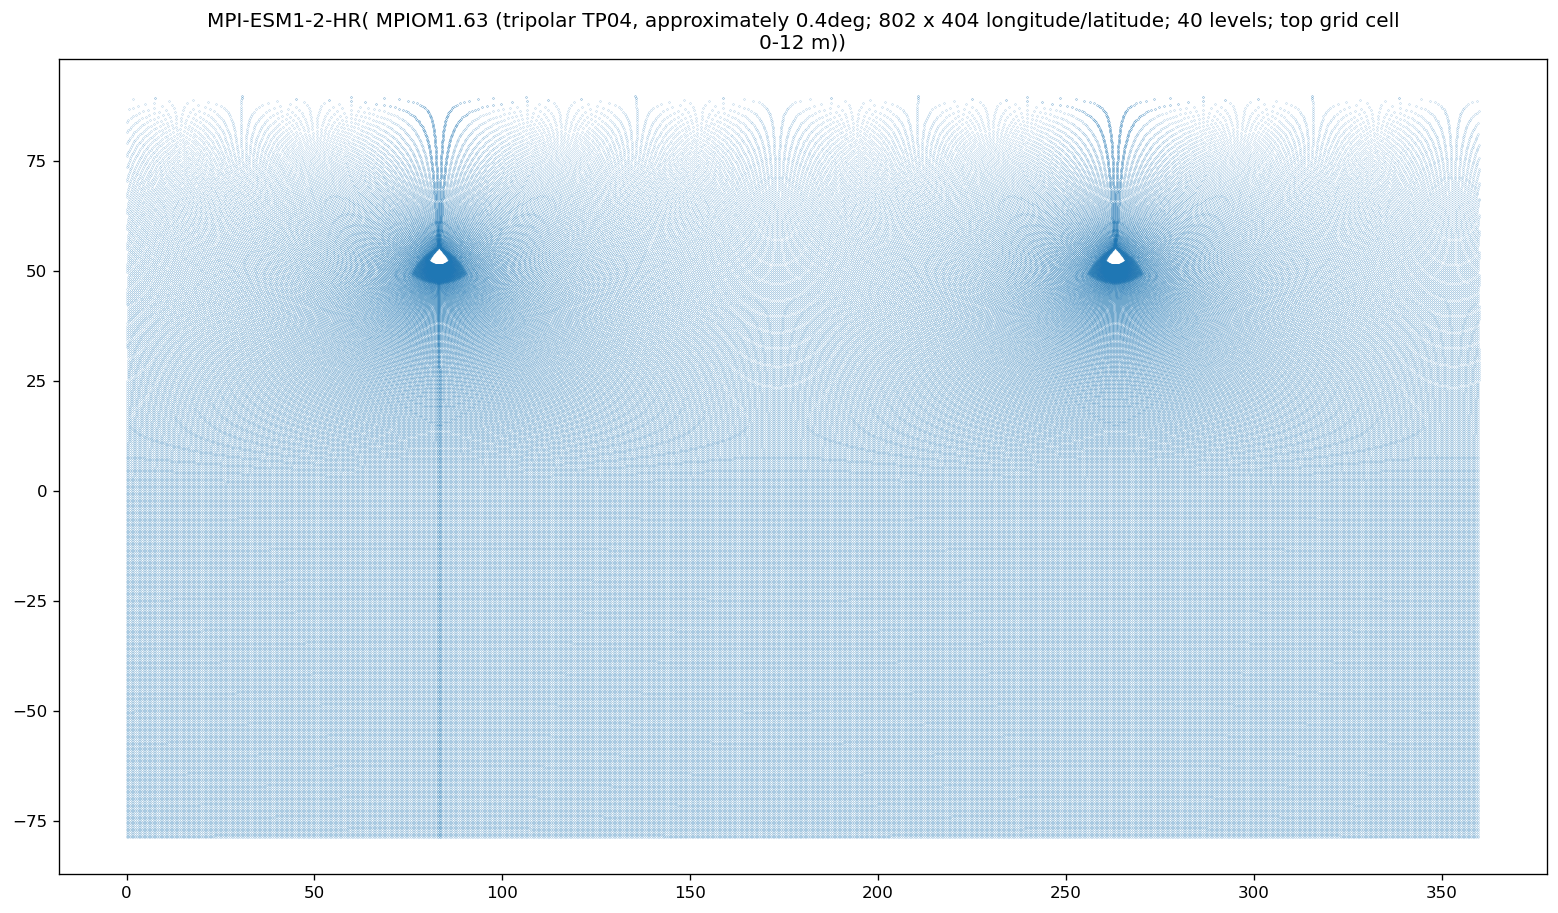

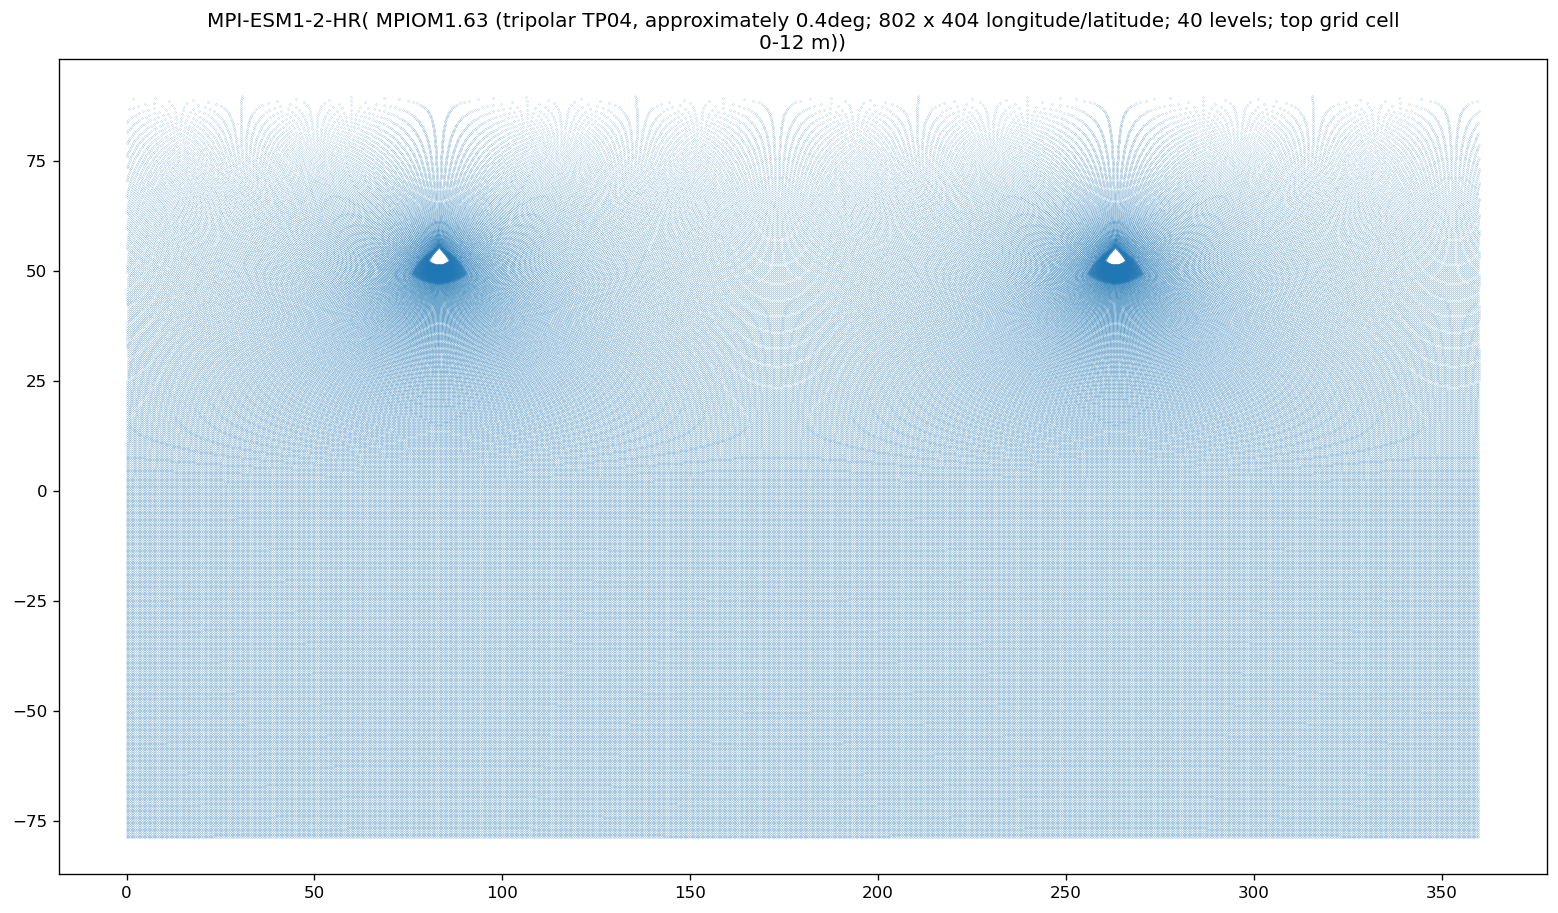

In [5]:
# The halo region can be spotted when creating a scatter plot for the grids
plot_curv_grid(ds_mpiesmlr_halo)
plot_curv_grid(ds_mpiesmlr)
plot_curv_grid(ds_mpiesmhr_halo)
plot_curv_grid(ds_mpiesmhr)

### Specify output grid

In [6]:
# Specify a global 1deg target grid
ds_out=clore.Grid(grid_instructor=(1.,)).ds
ds_out

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    lon_bnds  (lon, bnds) float64 -180.0 -179.0 -179.0 ... 179.0 179.0 180.0

### Preaparing generation of remapping weights

Duplicated cells of the halo will lead to wrong values in the halo region for the conservative method and might crash bilinear and patch method remapping weights generation.

#### Test out the following ideas

- Provide an input mask for the halo cells to `xesmf.Regridder`
- Set the entries of the remapping matrix `xesmf.Regridder.weights` of halo cells to 0
- Use the recently implemented adaptive masking option `skipna` when applying remapping weights

In [7]:
# Function to set the contribution of certain source grid cells to 0
def add_zeros_to_weights(weights, zero_mask):
    """Add zeros to the regridding weights sparse matrix according to the specified source mask.

    Parameters
    ----------
    weights : scipy.sparse.coo_matrix
      Sparse weights matrix.
    zero_mask: 2D numpy.array
      Array with values != 0, where to set weight contributions to 0      

    Returns
    -------
    weights : scipy.sparse.coo_matrix
      Sparse weights matrix.
    """
    
    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    M = weights.tolil()
    tozero=np.where(zero_mask.ravel()!=0)  # Get indices where to set weight matrix to 0
    M[:,tozero]=0  # Set weight matrix entries to 0
    return sps.coo_matrix(M)

In [8]:
# Masks for add_zeroes_to_weights
mask_lr = np.zeros_like(ds_mpiesmlr_halo.latitude)
mask_hr = np.zeros_like(ds_mpiesmhr_halo.latitude)
mask_lr[:,[0,-1]] = 1
mask_hr[:,[0,-1]] = 1
mask_hr[[0,1],:]  = 1

# Masks for the xesmf.Regridder input
mask_lr_regridder = np.ones_like(ds_mpiesmlr_halo.latitude, dtype=bool)
mask_hr_regridder = np.ones_like(ds_mpiesmhr_halo.latitude, dtype=bool)
mask_lr_regridder[:,[0,-1]] = False
mask_hr_regridder[:,[0,-1]] = False
mask_hr_regridder[[0,1],:]  = False

# Set up datasets with masks
ds_mpiesmlr_halo_mask = ds_mpiesmlr_halo.copy()
ds_mpiesmlr_halo_mask['mask'] = xr.DataArray(data=mask_lr_regridder, dims=("j", "i"))
ds_mpiesmhr_halo_mask = ds_mpiesmhr_halo.copy()
ds_mpiesmhr_halo_mask['mask'] = xr.DataArray(data=mask_hr_regridder, dims=("j", "i"))

In [9]:
# In case of problems, activate ESMF verbose mode
import ESMF
ESMF.Manager(debug=True)

# Regridding methods
method_list = ['nearest_s2d', 'bilinear', 'patch', 'conservative']

# Function to generate the weights
#   If grids have problems of degenerated cells near the poles there is the ignore_degenerate option
def regrid(ds_in, ds_out, method, periodic, ignore_degenerate=None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic=periodic, 
                        ignore_degenerate=ignore_degenerate, unmapped_to_nan=True) 

### Generate the weights

In [10]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo[method]=regrid(ds_mpiesmlr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=None)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 447 ms, sys: 32.1 ms, total: 479 ms
Wall time: 479 ms
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 3.8 s, sys: 317 ms, total: 4.11 s
Wall time: 4.12 s
-------------
MPI-ESM-1-2-LR patch
CPU times: user 31 s, sys: 541 ms, total: 31.5 s
Wall time: 31.5 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 3.02 s, sys: 68.1 ms, total: 3.09 s
Wall time: 3.09 s


In [11]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo[method]=regrid(ds_mpiesmhr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=None)

-------------
MPI-ESM-1-2-HR nearest_s2d
CPU times: user 850 ms, sys: 27.9 ms, total: 878 ms
Wall time: 876 ms
-------------
MPI-ESM-1-2-HR bilinear


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
MPI-ESM-1-2-HR patch


ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

-------------
MPI-ESM-1-2-HR conservative
CPU times: user 9.9 s, sys: 164 ms, total: 10.1 s
Wall time: 10.1 s


### The logfile

The halo consists of duplicated cells, however, it occures that the cell vertices are not copied and the cells are thereby collapsing to lines or points, or the cell centers are outside their bounds. Strangely in this case, the conservative remapping weights generation works, but not the bilinear and patch remapping weights generation.
With the halo removed, it works fine for every method (not shown here).

In [12]:
!ls *ESMF_LogFile

PET0.ESMF_LogFile


In [13]:
!cat PET0.ESMF_LogFile

20210727 153328.057 INFO             PET0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
20210727 153328.057 INFO             PET0 !!! THE ESMF_LOG IS SET TO OUTPUT ALL LOG MESSAGES !!!
20210727 153328.057 INFO             PET0 !!!     THIS MAY CAUSE SLOWDOWN IN PERFORMANCE     !!!
20210727 153328.057 INFO             PET0 !!! FOR PRODUCTION RUNS, USE:                      !!!
20210727 153328.057 INFO             PET0 !!!                   ESMF_LOGKIND_Multi_On_Error  !!!
20210727 153328.057 INFO             PET0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
20210727 153328.057 INFO             PET0 Running with ESMF Version   : 8.0.1
20210727 153328.057 INFO             PET0 ESMF library build date/time: "Nov 13 2020" "06:24:17"
20210727 153328.057 INFO             PET0 ESMF library build location : /home/conda/feedstock_root/build_artifacts/esmf_1605247943261/work
20210727 153328.057 INFO             PET0 ESMF_COMM                   : mpich3
20210727 153328.057 INFO 

### Trying again with the `ignore_degenerate` option and only for conservative and bilinear

In [14]:
method_list = ['bilinear', 'conservative']

In [15]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo={}
for method in method_list:    
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo[method]=regrid(ds_mpiesmlr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=True)

-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 4.05 s, sys: 272 ms, total: 4.32 s
Wall time: 4.33 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 3.07 s, sys: 84.1 ms, total: 3.16 s
Wall time: 3.16 s


In [16]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo={}
for method in method_list:    
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo[method]=regrid(ds_mpiesmhr_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=True)

-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 11.7 s, sys: 696 ms, total: 12.4 s
Wall time: 12.4 s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 9.78 s, sys: 148 ms, total: 9.93 s
Wall time: 9.93 s


### Create the weights with masked halo

In [17]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo_mask={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo_mask[method]=regrid(ds_mpiesmlr_halo_mask, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 4.2 s, sys: 240 ms, total: 4.44 s
Wall time: 4.44 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 3.07 s, sys: 60 ms, total: 3.13 s
Wall time: 3.13 s


In [18]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo_mask={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo_mask[method]=regrid(ds_mpiesmhr_halo_mask, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 12.5 s, sys: 647 ms, total: 13.1 s
Wall time: 13.1 s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 10.4 s, sys: 184 ms, total: 10.5 s
Wall time: 10.6 s


### Create the weights and set weight matrix entries of halo cells to 0

In [19]:
# Generating the weights for all specified methods
regridder_mpiesmlr_halo_zero={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr_halo_zero[method]=regrid(ds_mpiesmlr_halo, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 4.19 s, sys: 276 ms, total: 4.47 s
Wall time: 4.47 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 3.13 s, sys: 71.9 ms, total: 3.2 s
Wall time: 3.2 s


In [20]:
# Generating the weights for all specified methods
regridder_mpiesmhr_halo_zero={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr_halo_zero[method]=regrid(ds_mpiesmhr_halo, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 12 s, sys: 800 ms, total: 12.8 s
Wall time: 12.8 s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 10 s, sys: 160 ms, total: 10.2 s
Wall time: 10.2 s


In [21]:
for method in method_list:
    regridder_mpiesmlr_halo_zero[method].weights = add_zeros_to_weights(
        regridder_mpiesmlr_halo_zero[method].weights, 
        mask_lr
    )
    regridder_mpiesmlr_halo_zero[method].weights = xe.smm.add_nans_to_weights(
        regridder_mpiesmlr_halo_zero[method].weights
    )

for method in method_list:
    regridder_mpiesmhr_halo_zero[method].weights = add_zeros_to_weights(
        regridder_mpiesmhr_halo[method].weights,
        mask_hr
    )
    regridder_mpiesmhr_halo_zero[method].weights = xe.smm.add_nans_to_weights(
        regridder_mpiesmhr_halo_zero[method].weights
    )

### Create the weights without the halo

In [22]:
# Generating the weights for all specified methods
regridder_mpiesmlr={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_mpiesmlr[method]=regrid(ds_mpiesmlr, \
                                            ds_out, method, \
                                            periodic=True, \
                                            ignore_degenerate=None)

-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 4.25 s, sys: 280 ms, total: 4.53 s
Wall time: 4.53 s
-------------
MPI-ESM-1-2-LR conservative
CPU times: user 3.14 s, sys: 84 ms, total: 3.22 s
Wall time: 3.22 s


In [23]:
# Generating the weights for all specified methods
regridder_mpiesmhr={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-HR", method)
    %time regridder_mpiesmhr[method]=regrid(ds_mpiesmhr, \
                                            ds_out, method, \
                                            periodic=True, \
                                            ignore_degenerate=None)

-------------
MPI-ESM-1-2-HR bilinear
CPU times: user 12.4 s, sys: 664 ms, total: 13.1 s
Wall time: 13.1 s
-------------
MPI-ESM-1-2-HR conservative
CPU times: user 9.99 s, sys: 136 ms, total: 10.1 s
Wall time: 10.1 s


### Regrid

In [24]:
for method in method_list:
    ds_out["tos_mpiesmlr_halo_mask_"+method]=regridder_mpiesmlr_halo_mask[method](ds_mpiesmlr_halo_mask.tos)
    ds_out["tos_mpiesmhr_halo_mask_"+method]=regridder_mpiesmhr_halo_mask[method](ds_mpiesmhr_halo_mask.tos)
    ds_out["tos_mpiesmlr_halo_zero_"+method]=regridder_mpiesmlr_halo_zero[method](ds_mpiesmlr_halo.tos)
    ds_out["tos_mpiesmhr_halo_zero_"+method]=regridder_mpiesmhr_halo_zero[method](ds_mpiesmhr_halo.tos)
    ds_out["tos_mpiesmlr_halo_"+method]=regridder_mpiesmlr_halo[method](ds_mpiesmlr_halo.tos)
    ds_out["tos_mpiesmhr_halo_"+method]=regridder_mpiesmhr_halo[method](ds_mpiesmhr_halo.tos)
    ds_out["tos_mpiesmlr_halo_skipna_"+method]=regridder_mpiesmlr_halo[method](ds_mpiesmlr_halo.tos,
                                                                               skipna=True, na_thres=1)
    ds_out["tos_mpiesmhr_halo_skipna_"+method]=regridder_mpiesmhr_halo[method](ds_mpiesmhr_halo.tos,
                                                                               skipna=True, na_thres=1)
    ds_out["tos_mpiesmlr_skipna_"+method]=regridder_mpiesmlr[method](ds_mpiesmlr.tos,
                                                                     skipna=True, na_thres=1)
    ds_out["tos_mpiesmhr_skipna_"+method]=regridder_mpiesmhr[method](ds_mpiesmhr.tos,
                                                                     skipna=True, na_thres=1)    
    ds_out["tos_mpiesmlr_"+method]=regridder_mpiesmlr[method](ds_mpiesmlr.tos)
    ds_out["tos_mpiesmhr_"+method]=regridder_mpiesmhr[method](ds_mpiesmhr.tos)   

/home/maurti/git/clisopsdev/xesmf/xesmf/frontend.py:535: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### Compare result

For the conservative method, either method to remove the halo contribution seems to be working more or less OK. "Normalizing the halo away" with the `skipna` option, is not working as good as expected. The reason(s) for that are yet unclear to me. The best result is achieved when cutting off the halo, which is not possible for grids that have partly duplicated rows or columns. 

For the bilinear method, the halo has to be either cut off or `ignore_degenerate` has to be set to `True`.

In [25]:
# Calculate differences
for method in method_list:
    ds_out["diff_mask_mpiesmhr_"+method]=ds_out["tos_mpiesmhr_"+method]-ds_out["tos_mpiesmhr_halo_mask_"+method]
    ds_out["diff_mask_mpiesmlr_"+method]=ds_out["tos_mpiesmlr_"+method]-ds_out["tos_mpiesmlr_halo_mask_"+method]
    ds_out["diff_zero_mpiesmhr_"+method]=ds_out["tos_mpiesmhr_"+method]-ds_out["tos_mpiesmhr_halo_zero_"+method]
    ds_out["diff_zero_mpiesmlr_"+method]=ds_out["tos_mpiesmlr_"+method]-ds_out["tos_mpiesmlr_halo_zero_"+method]
    ds_out["diff_skipna_mpiesmhr_"+method]=ds_out["tos_mpiesmhr_skipna_"+method]-ds_out["tos_mpiesmhr_halo_skipna_"+method]
    ds_out["diff_skipna_mpiesmlr_"+method]=ds_out["tos_mpiesmlr_skipna_"+method]-ds_out["tos_mpiesmlr_halo_skipna_"+method]
    ds_out["diff_halo_mpiesmhr_"+method]=ds_out["tos_mpiesmhr_"+method]-ds_out["tos_mpiesmhr_halo_"+method]
    ds_out["diff_halo_mpiesmlr_"+method]=ds_out["tos_mpiesmlr_"+method]-ds_out["tos_mpiesmlr_halo_"+method]
    
# Print maximum differences
for method in method_list:
    for submethod in ["halo", "skipna", "mask", "zero"]:
        print(method, "-", submethod,"(min, max):")
        print(" LR: ", float(np.amin(ds_out["diff_"+submethod+"_mpiesmlr_"+method])),
              float(np.amax(ds_out["diff_"+submethod+"_mpiesmlr_"+method])))
        print(" HR: ", float(np.amin(ds_out["diff_"+submethod+"_mpiesmhr_"+method])),
              float(np.amax(ds_out["diff_"+submethod+"_mpiesmhr_"+method])))

bilinear - halo (min, max):
 LR:  -3.552713678800501e-15 7.105427357601002e-15
 HR:  -2.311484337269576e-13 2.97761815204467e-13
bilinear - skipna (min, max):
 LR:  -7.105427357601002e-15 7.105427357601002e-15
 HR:  -0.0009894568917181434 0.00037517536884346114
bilinear - mask (min, max):
 LR:  0.0 0.0
 HR:  0.0 0.0
bilinear - zero (min, max):
 LR:  -1.842886303066176 29.951118762881848
 HR:  0.0 0.0
conservative - halo (min, max):
 LR:  -60.52488862457501 3.799986213973993
 HR:  -47.98404820085579 1.8999533425298702
conservative - skipna (min, max):
 LR:  -0.8947611765162398 2.1026121189823677
 HR:  -0.2350393430826827 0.45403331552618464
conservative - mask (min, max):
 LR:  -0.00029257222663758853 0.00040615717161429643
 HR:  0.0 0.0
conservative - zero (min, max):
 LR:  -0.00029257222663758853 0.00040615717161429643
 HR:  0.0 0.0


In [26]:
import math
def plot_ds(ds, ds_list, diff=False, title=None):
    # Create panel plot
    fig, axes = plt.subplots(ncols=1, nrows=len(ds_list), 
                             figsize=(16, 6*(len(ds_list))),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    if title: plt.suptitle(title, fontsize=16, va="top", ha="center", y=0.9)
        
    i=0
    for ds_i in ds_list:
        if diff==True:
            vmin=-0.1
            vmax=0.1
        else:
            vmin=-5
            vmax=35
        ds[ds_i].plot.pcolormesh(ax=axes[i], shading="flat", vmin=vmin, vmax=vmax)
            
        axes[i].title.set_text("\n".join(textwrap.wrap(ds_i, 40)));  
        i+=1

    for axis in axes.flatten():
        axis.coastlines();
        axis.set_xlabel('lon');
        axis.set_ylabel('lat');

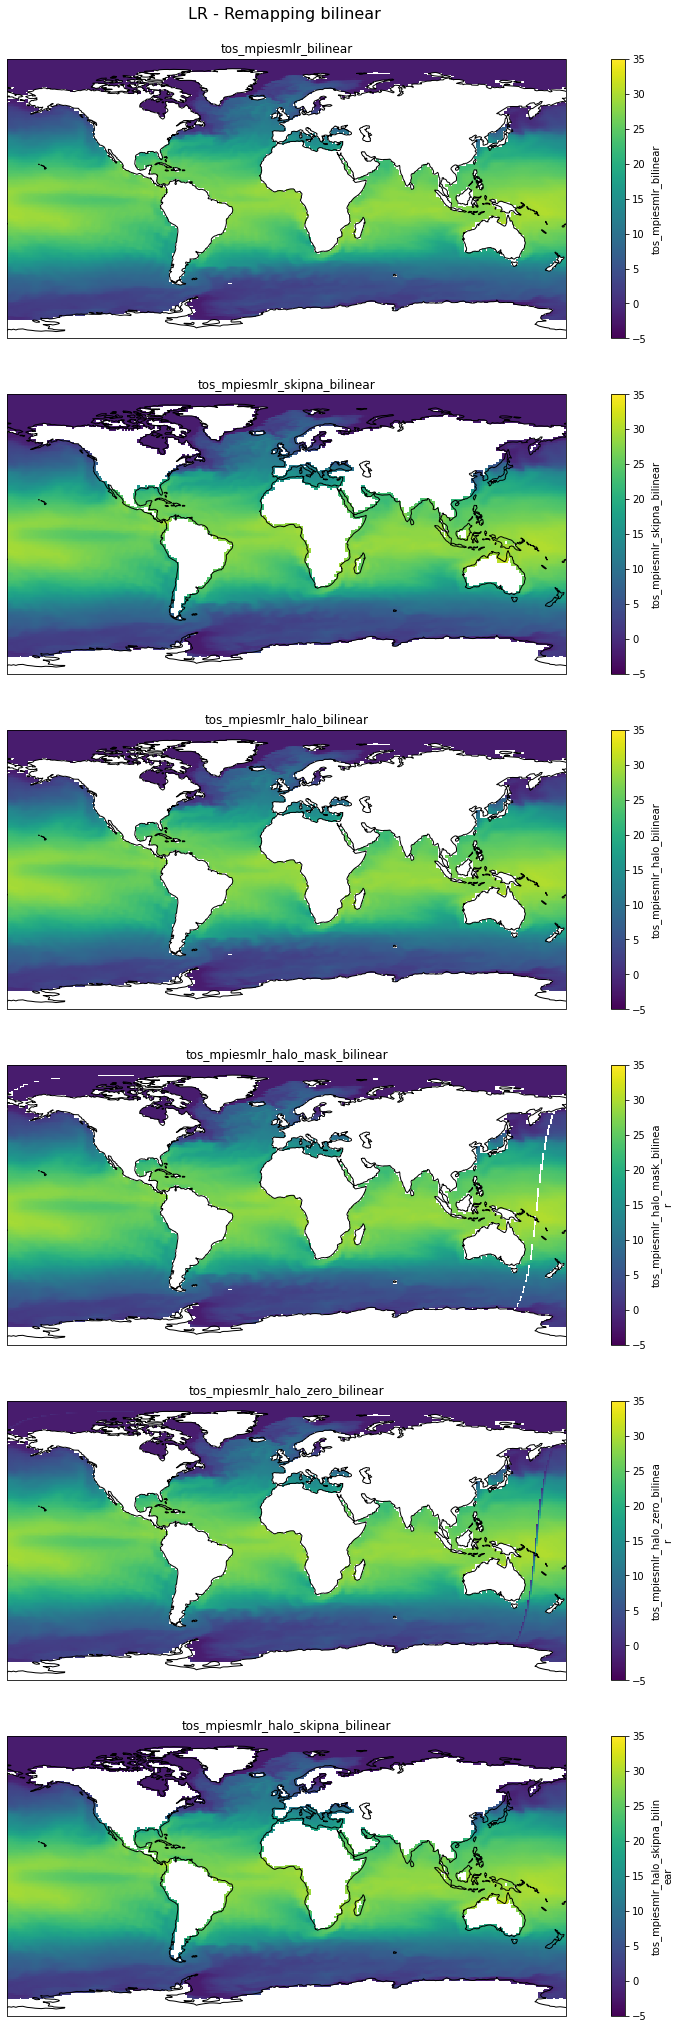

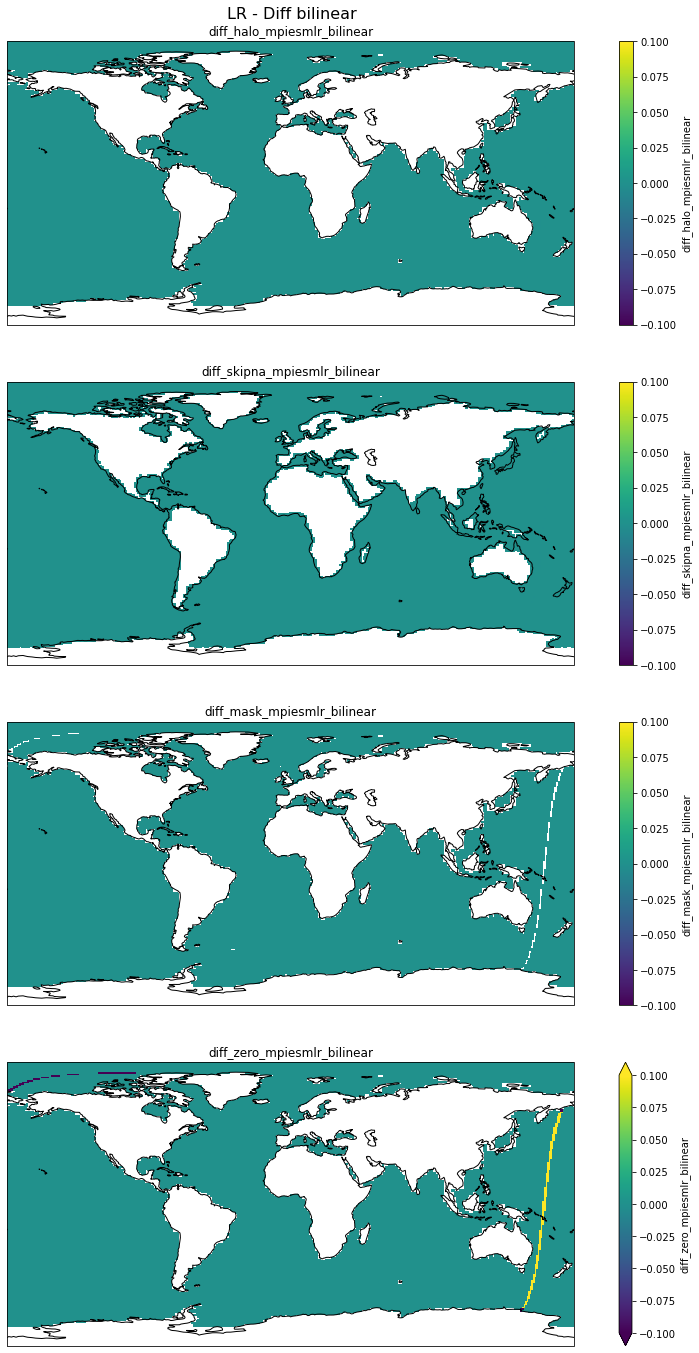

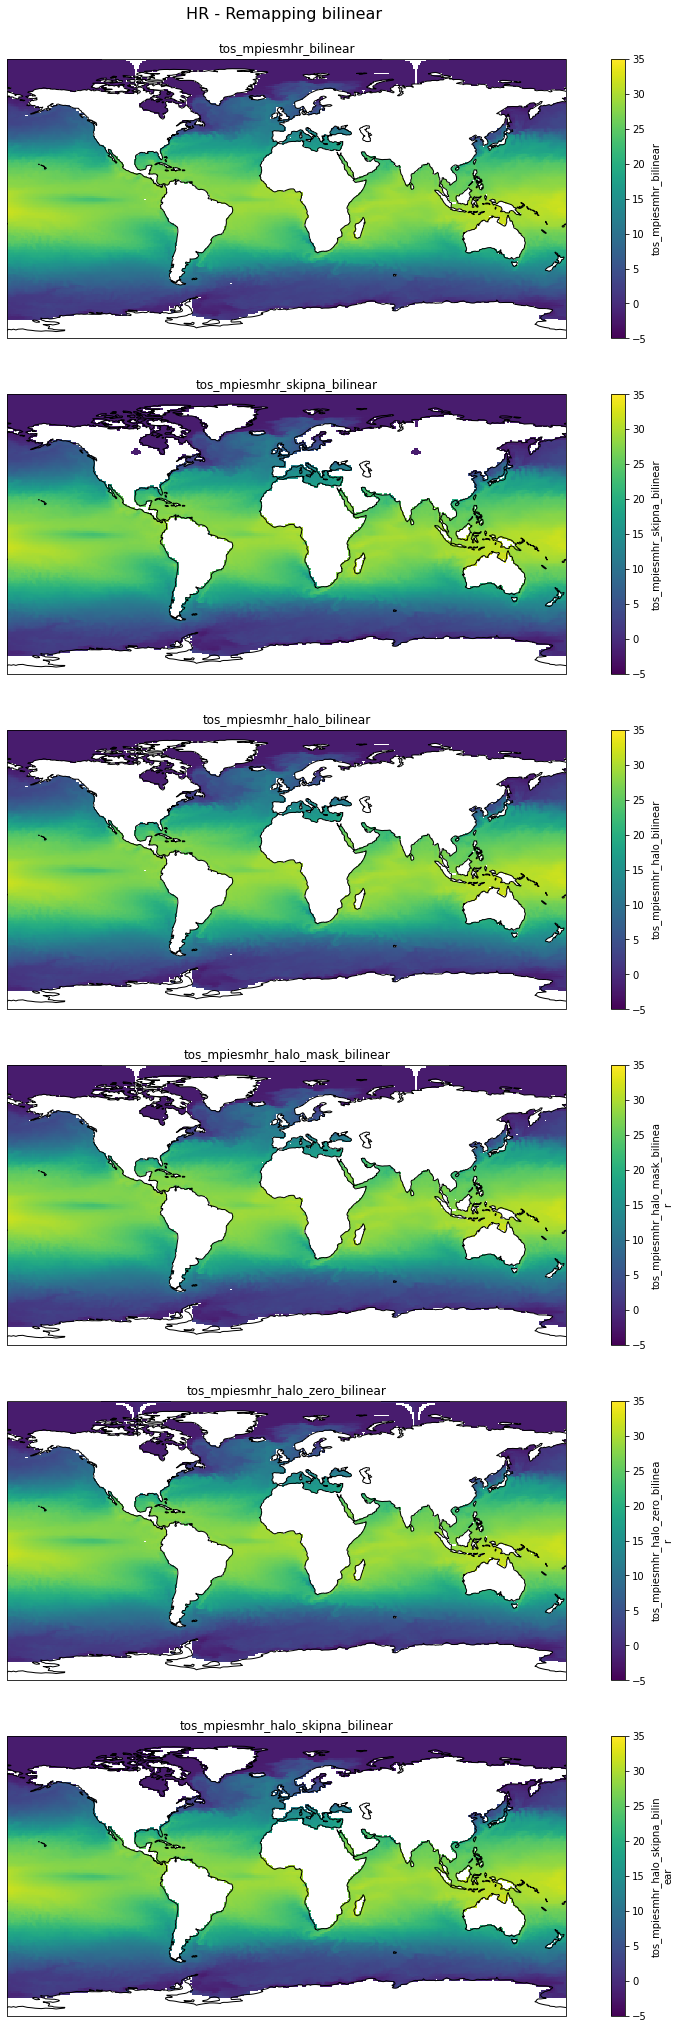

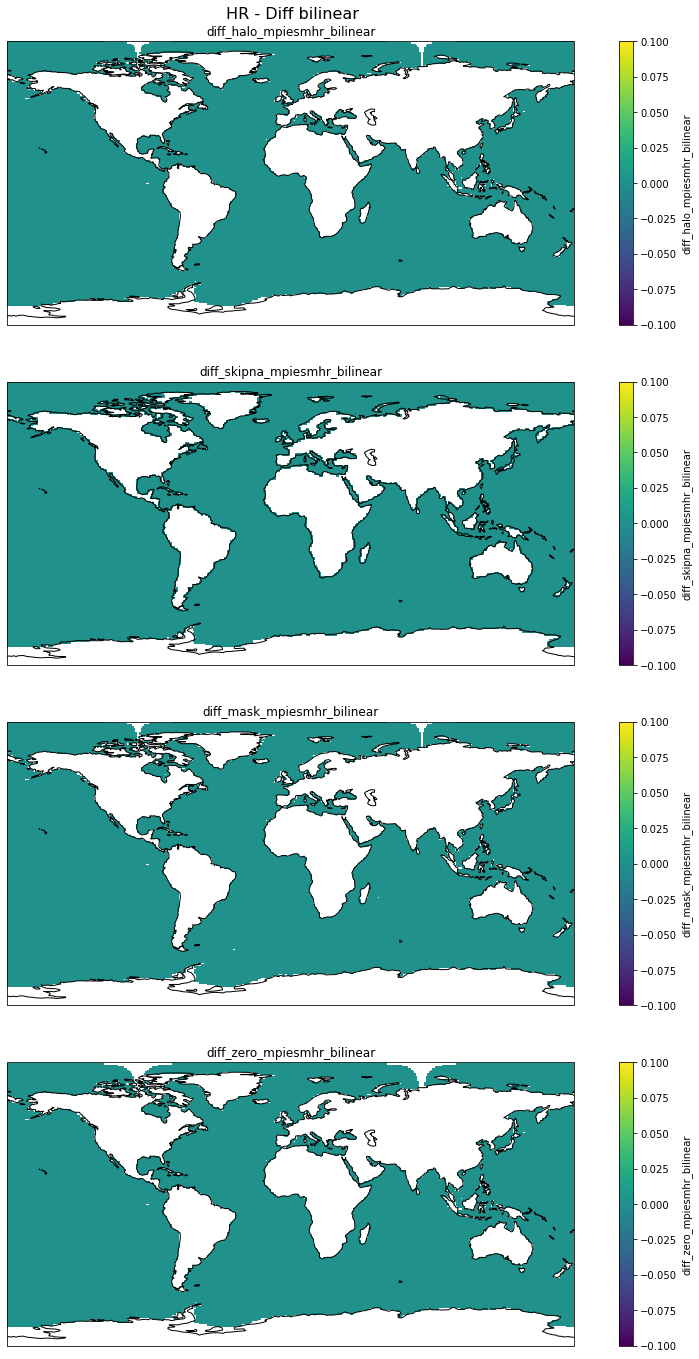

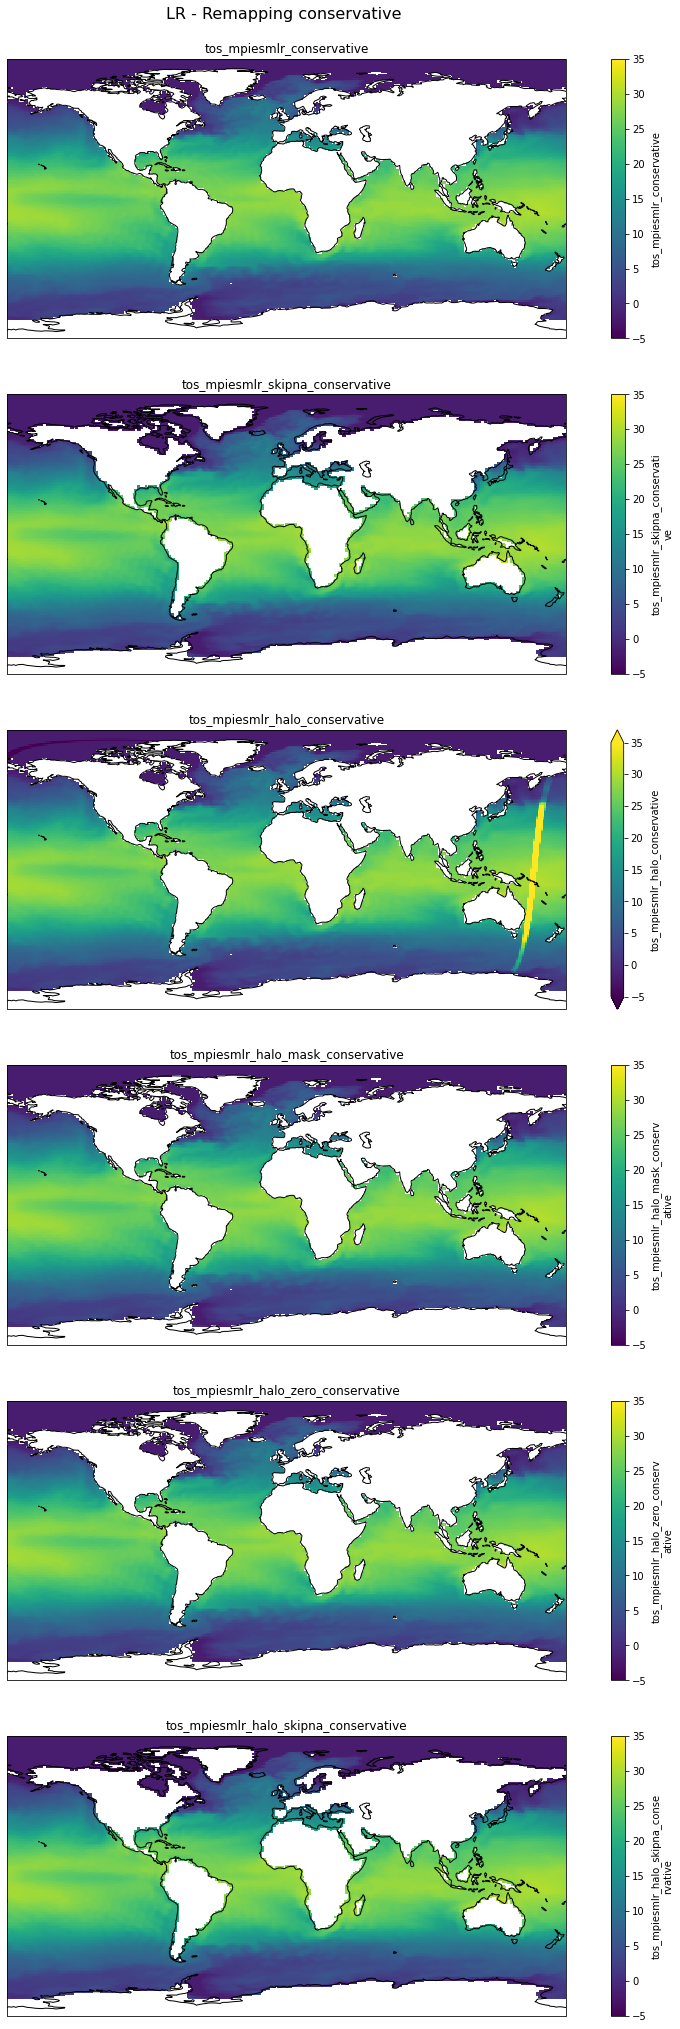

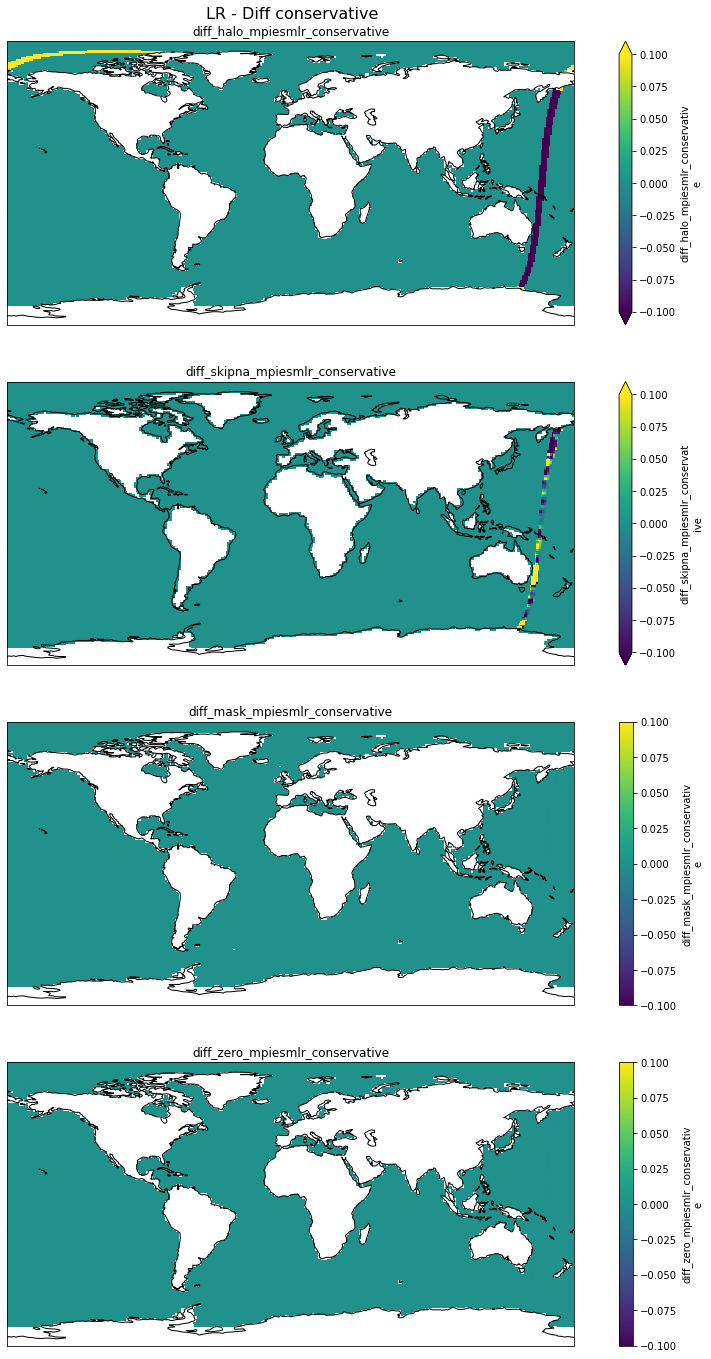

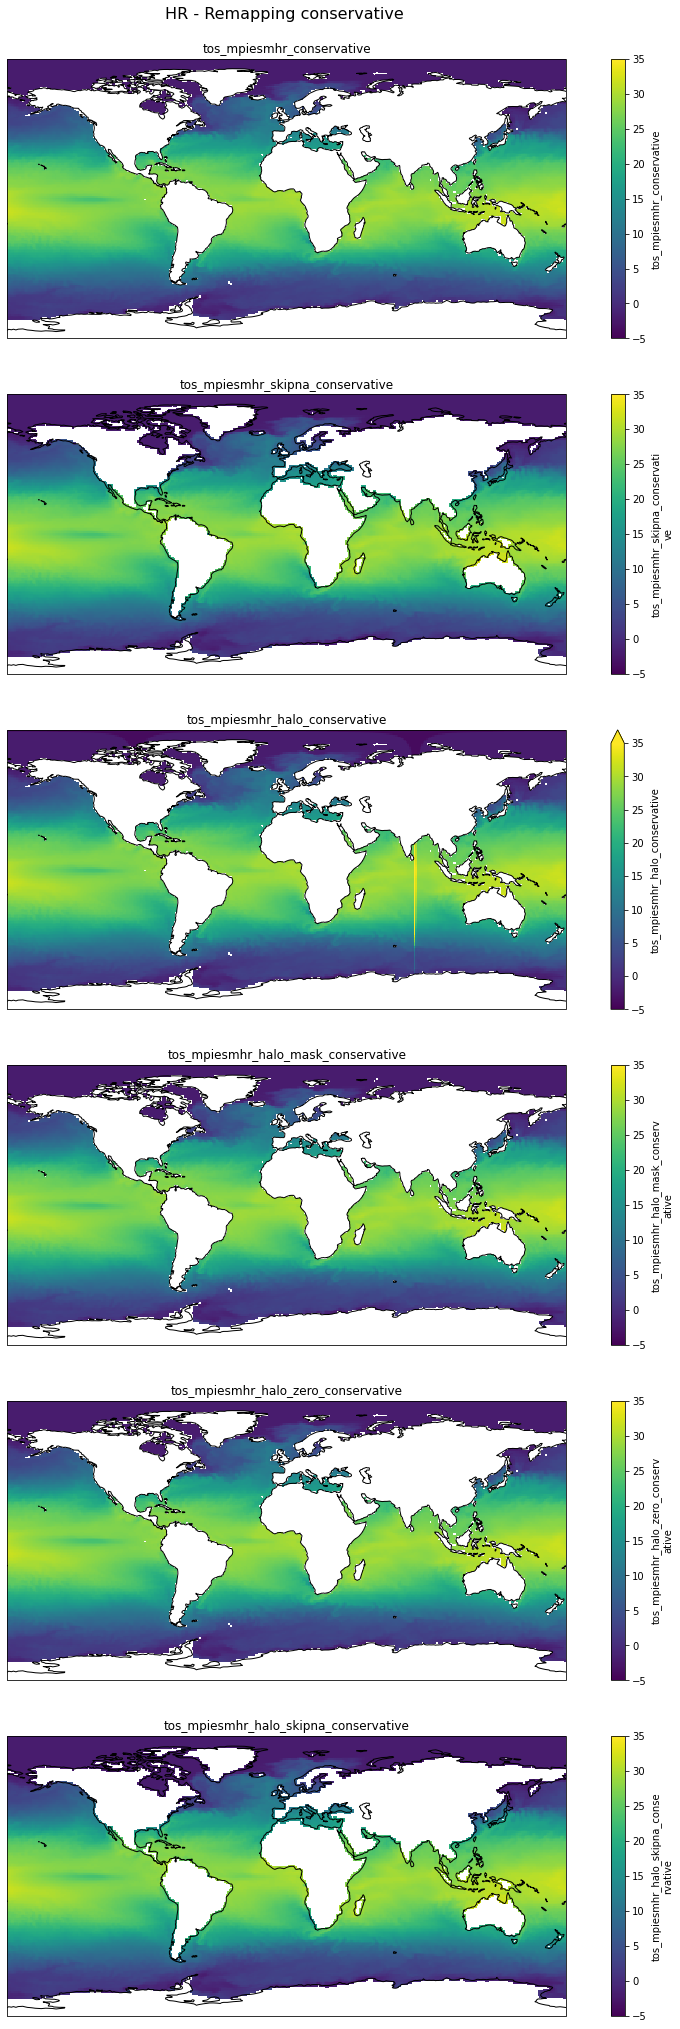

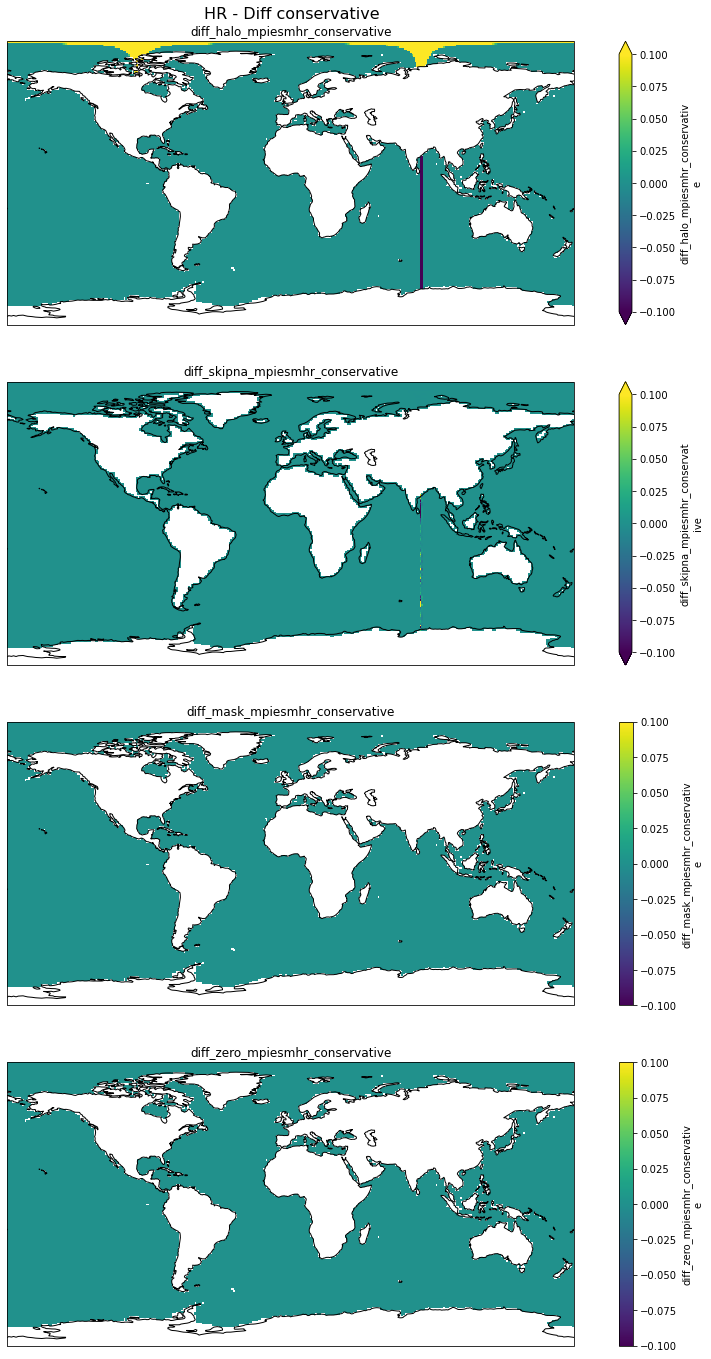

In [27]:
# Plot differences
for method in method_list:
    # LR
    plot_ds(ds_out, ["tos_mpiesmlr_"+method,
                     "tos_mpiesmlr_skipna_"+method,
                     "tos_mpiesmlr_halo_"+method,
                     "tos_mpiesmlr_halo_mask_"+method, 
                     "tos_mpiesmlr_halo_zero_"+method,
                     "tos_mpiesmlr_halo_skipna_"+method],
           title="LR - Remapping "+method)       
    plot_ds(ds_out, ["diff_halo_mpiesmlr_"+method, 
                     "diff_skipna_mpiesmlr_"+method,
                     "diff_mask_mpiesmlr_"+method, 
                     "diff_zero_mpiesmlr_"+method],
            diff=True, title="LR - Diff "+method)
    # HR
    plot_ds(ds_out, ["tos_mpiesmhr_"+method, 
                     "tos_mpiesmhr_skipna_"+method,
                     "tos_mpiesmhr_halo_"+method,
                     "tos_mpiesmhr_halo_mask_"+method, 
                     "tos_mpiesmhr_halo_zero_"+method, 
                     "tos_mpiesmhr_halo_skipna_"+method], 
            title="HR - Remapping "+method)
    plot_ds(ds_out, ["diff_halo_mpiesmhr_"+method, 
                     "diff_skipna_mpiesmhr_"+method,
                     "diff_mask_mpiesmhr_"+method, 
                     "diff_zero_mpiesmhr_"+method],
            diff=True, title="HR - Diff "+method)